# EIGSEP Image Fit

Aaron Parsons

In [1]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.image import imread
import torch
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
from scripts.img_pkg import PRM_ORDER, HorizonImage, PositionSolver
import healpy
import pymc as pm
import pytensor
pytensor.config.cxx = ""    #type: ignore
import pytensor.tensor as pt
from pytensor.compile.ops import as_op
import os, sys, glob, tqdm
import multiprocessing as mp
import arviz, corner

%matplotlib widget

In [2]:
CACHE_FILE = 'marjum_dem.npz'
dem = DEM(cache_file=CACHE_FILE)

In [3]:
dem['platform'] = np.array([1648, 2024, 1796])

meta = {}
meta['0817'] = {
    'best_prms': ( 1732.31,  2069.73,   1760.89,  1.4682,  3.6963, -0.0521,  9849.36),  #[LOSS= 0.0378]
    'ant_px': (2*1366, 2*1221),
}
meta['0833'] = {
    'best_prms': ( 1611.38,  1847.62,   1659.85,  1.2062,  1.2401, -0.0250,  5072.38),  #[LOSS= 0.0254]
    'ant_px': (1606, 2700),
}

#meta['0834'] = {
#    'best_prms': ( 1642.45,  1887.80,   1678.94,  1.1787,  1.2417, -0.0310,  2933.66),  #[LOSS= 0.0685]
#    'ant_px': (1622, 2251),
#}

meta['0860'] = {
    #'best_prms': ( 1539.90,  1989.78,   1765.54,  1.5423,  0.6162,  0.1541,  2328.29),  #[LOSS= 0.0206]
    #'best_prms': ( 1538.80,  2001.28,   1765.46,  1.5411,  0.6109,  0.1589,  2328.29),  #[LOSS= 0.0166]
    'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5421,  0.6131,  0.1584,  2328.30),  #[LOSS= 0.0151]
    'ant_px': (2924, 1945),
}

for k in meta.keys():
    dem[k] = np.asarray(meta[k]['best_prms'][:3], dtype=np.float32)
    
files = sorted(glob.glob('//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/*.jpg'))
#files = sorted(glob.glob('/home/aparsons/Downloads/IMG_08*.jpg'))[-1:]
print(files)
imgs = [HorizonImage(f, meta) for f in files]
imgs = [img for img in imgs if img.key in meta]


['//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/IMG_0817.jpg', '//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/IMG_0833.jpg', '//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/IMG_0860.jpg']


In [4]:
dem.interp_alt(imgs[-1].prms['e'], imgs[-1].prms['n'])


1758

In [5]:
# overlay ray tracing

if False:
    fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(7, 4 * 3))
    r_imgs = {}
    sl = slice(None, None, 4)
    img_pkg = imgs[-1]
    axes[0].imshow(img_pkg.img[sl,sl], origin='lower')
    axes[2].imshow(img_pkg.img[sl,sl], origin='lower')
    r_imgs[img_pkg.key] = img_pkg.ray_distance(dem, img_pkg.get_rays()[...,sl,sl])
    axes[1].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar')
    axes[0].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar', alpha=0.4)
    plt.tight_layout()


In [6]:
# i = imgs[0]
# npz = np.load(i.npzfile)
# plt.figure()
# plt.imshow(npz['sky'])


In [7]:
if False:
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
    if len(imgs) == 1:
        axes = [axes]
    r_imgs = {}
    sl = slice(None, None, 8)
    for cnt, img_pkg in enumerate(imgs):
        axes[cnt].imshow(img_pkg.img[sl,sl], origin='lower')
        r_imgs[img_pkg.key] = img_pkg.ray_distance(dem, img_pkg.get_rays()[...,sl,sl])
        axes[cnt].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar', alpha=0.4)
    plt.tight_layout()

In [8]:
if False:
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
    if len(imgs) == 1:
        axes = [axes]
    for cnt, img_pkg in enumerate(imgs):
        axes[cnt].imshow(img_pkg.img, origin='lower')
        axes[cnt].imshow(img_pkg.sky_mask, origin='lower', alpha=0.3)
        axes[cnt].imshow(img_pkg.horizon_mask, origin='lower', alpha=0.3)
        mask = img_pkg.mask_near_horizon(50)
        x, y = img_pkg.choose_pixels(mask=mask, N=16000//3)
        is_sky = img_pkg.sky_mask[x, y]
        axes[cnt].plot(y[is_sky], x[is_sky], 'b,')
        axes[cnt].plot(y[~is_sky], x[~is_sky], 'r,')
        axes[cnt].plot(*img_pkg.meta['ant_px'], 'k+')

In [9]:
#nside = 512
##e0, n0, u0 = (1754, 2100, 1747)
#e0, n0, u0 = start_point = np.array((1767, 2095, 1759), dtype=float)
#rays = et.ray.healpix_rays(nside)
##e0, n0, u0 = start_point = np.array(dem['1P'], dtype=float)
##e0, n0, u0 = (0, 0, 1759)

In [10]:
#healpy.mollview(h.map)
#healpy.mollview(np.log10(ray_trace(start_point)), cmap='plasma')
#healpy.mollview(np.log10(r), cmap='plasma')
#healpy.mollview(np.log10(r2), cmap='plasma')
#healpy.mollview(T[-1], cmap='plasma')
#healpy.mollview((T_sky_full[:, 180]), cmap='plasma')

In [11]:
# for one image

I = imgs[2]
I.reset_pixel_choice()
I.horizon_ray_loss(dem, cnt=16000);
ant_ray = I.get_rays(np.array(I.meta['ant_px'][::-1]))
prms = dict(zip(PRM_ORDER, I.get_prms()))
r_ant = dem['platform'] - np.array([prms['e'], prms['n'], prms['u']])

delta_theta = np.arccos(np.dot(ant_ray, r_ant) / (np.linalg.norm(ant_ray) * np.linalg.norm(r_ant))) # rad
BOX_SIZE = 0.3 # m
sigma_theta = BOX_SIZE / np.linalg.norm(r_ant)

logL = -delta_theta / (2 * sigma_theta**2) # :0
logL
                        

'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5421,  0.6131,  0.1584,  2328.30),  #[LOSS= 0.0563]


-8694.42794836528

In [12]:
sigmas = (30.0, 30.0, 30.0, np.deg2rad(5.0), np.deg2rad(5.0), np.deg2rad(5.0), 0.1)
BOX_SIZE = 0.3 # m
ANT_POS_ERR = 20 #m
ant_pos_prior = np.array([1646, 2022, 1782])
fit_imgs = []
static_imgs = imgs
n_rays = 1600

pos_slvr = PositionSolver(ant_pos_prior, fit_imgs, static_imgs, n_rays, dem, ant_pos_err=20, box_size=0.3)

def build_model():
    """
    eps: per-pixel error rate for mismatches (small)
    """

    # @as_op(itypes=[pt.dvector], otypes=[pt.fscalar])
    # def horizon_mismatches_loss(theta):
    #     L = 0.0
    #     for cnt, img in enumerate(imgs):
    #         img.set_prms(tuple(theta[cnt*len(PRM_ORDER):(cnt+1)*len(PRM_ORDER)]))
    #         # L += img.horizon_ray_loss(dem, cnt=n_rays)
    #     return np.array(L / len(imgs), dtype=np.float32)

    # @as_op(itypes=[pt.dvector], otypes=[pt.fscalar])
    # def horizon_mismatches_loss(theta):
    #     L = 0.0
    #     for cnt, img in enumerate(imgs):
    #         img.set_prms(tuple(theta[cnt*len(PRM_ORDER):(cnt+1)*len(PRM_ORDER)]))
    #         L += img.horizon_ray_loss(dem, cnt=n_rays)
    #     return np.array(L / len(imgs), dtype=np.float32)

    with pm.Model() as model:
        pos_slvr.set_mcmc_sigmas()
        prms = pos_slvr.get_mcmc_prms()

        # prms=[]
        # sigmas = make_sigmas(imgs)
        # for cnt, img in enumerate(imgs):
        #     _sigmas = sigmas[cnt*len(PRM_ORDER): (cnt+1)*len(PRM_ORDER)]
        #     prms += [pm.Normal(f"{img.key}_{k}", mu=img.prms[k], sigma=sig) for k, sig in zip(PRM_ORDER, _sigmas)]     

        # ant_pos_prior = np.array([1646, 2022, 1782])
        # prms += [pm.Normal(f'ant_{k}', mu=v, sigma=ANT_POS_ERR) for k, v in zip('enu', ant_pos_prior)]
               
        theta = pt.stack(prms)
        # pos_slvr.set_mcmc_prms(theta)
        logp = pos_slvr.total_loss(theta)
        # L = horizon_mismatches_loss(theta)

        # logp = (N - L)*log(1-eps) + L*log(eps)
        # logp = len(imgs) * n_rays * (1 - L) * np.log(1.0 - eps) + len(imgs) * n_rays * L * np.log(eps)
        # for I in imgs:
        #     ant_pos = np.array(prms[-3:])
        #     I.ant_loss(ant_pos, BOX_SIZE)
        #     print('logp', logp.eval())
        #     print('logL', logL)
        #     logp += logL
            
        pm.Potential("lik", logp)

    return model

In [13]:
if True:
    with build_model() as model:
        # step = pm.DEMetropolisZ(
        step = pm.Metropolis(
            S=np.array(pos_slvr.sigmas),
            scaling=.01,      # much bigger than 1e-3, TODO: may need to tune this
            tune='scaling',   # let it adapt scale
            tune_interval=50, # adapt more often than default 100
        )
        
        trace = pm.sample(
            draws=2000,
            tune=1000,
            chains=4,   #TODO: go back to 4 once this works
            step=step,
            cores=4,
            random_seed=42,
            progressbar=True,
        )
    arviz.to_netcdf(trace, f"{I.key}_trace.nc");
    print(f"Accepted step fraction = {float(trace.sample_stats.accepted.mean()): 4.3f}")
    # rejecting most steps = steps too big
    # accepting most steps = steps too small

logp -0.0
logL True_div.0
logp Add.0
logL True_div.0
logp Add.0
logL True_div.0


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ant_e]
>Metropolis: [ant_n]
>Metropolis: [ant_u]


Output()

/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 195 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Accepted step fraction =  0.252


In [14]:
trace_files = sorted(glob.glob("*.nc"))
print(trace_files)
traces = {f.split('_')[0]: arviz.from_netcdf(f) for f in trace_files}


['0860_trace.nc']


In [15]:
# Load the trace file
trace = arviz.from_netcdf("0860_trace.nc")

# Check if it actually has samples (not constants)
print("Checking if samples vary:")
for var in trace.posterior.data_vars:
    data = trace.posterior[var].values
    print(f"{var}: shape={data.shape}, std={data.std():.6e}, range={data.max()-data.min():.6e}")

Checking if samples vary:
ant_e: shape=(4, 2000, 3), std=1.023968e-01, range=7.549894e-01
ant_n: shape=(4, 2000, 3), std=8.585037e+00, range=8.467929e+01
ant_u: shape=(4, 2000, 3), std=1.030777e-01, range=7.782211e-01


In [16]:
# Check if 0860 parameters actually vary
posterior = traces['0860'].posterior

for var in posterior.data_vars:
    data = posterior[var].values.flatten()
    print(f"{var}: min={data.min():.4f}, max={data.max():.4f}, "
          f"unique={len(np.unique(data))}, std={data.std():.6f}")

ant_e: min=1803.5349, max=1804.2899, unique=5105, std=0.102397
ant_n: min=1803.4997, max=1888.1790, unique=4865, std=8.585037
ant_u: min=1803.5136, max=1804.2918, unique=8203, std=0.103078


In [17]:
traces

{'0860': Inference data with groups:
 	> posterior
 	> sample_stats}

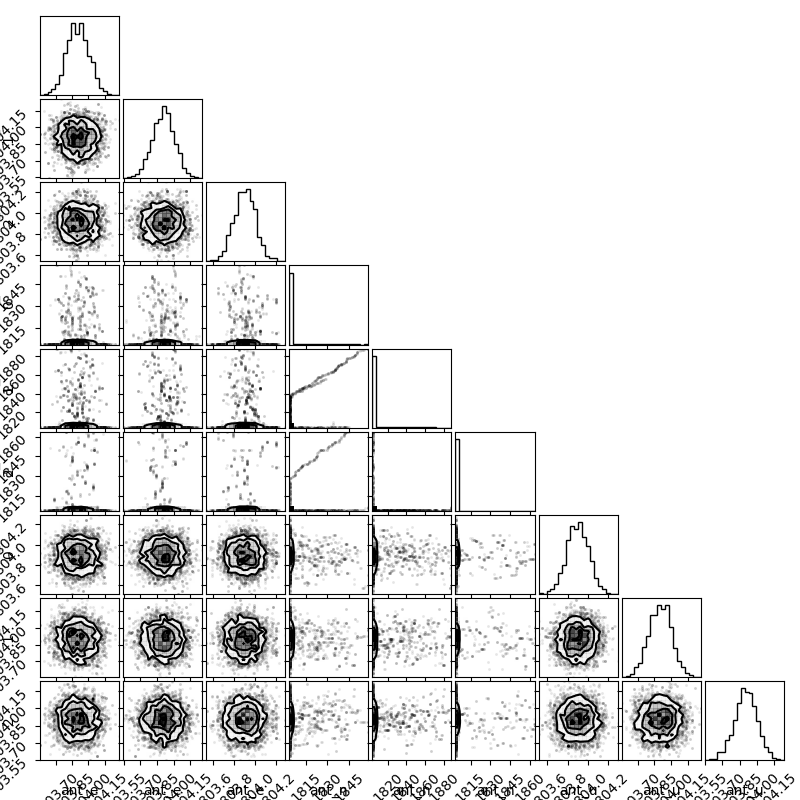

In [18]:
fig = plt.figure(figsize=(8, 8))
# type(traces['0860'])
corner.corner(traces['0860'], fig=fig);

In [19]:
def plot_img(ax, data, res=dem.res, xlabel=True, ylabel=True,
             colorbar=False, cmap='terrain', erng=None, nrng=None, **kw):
    '''Plot maps with standard format.'''
    if nrng is None:
        nrng = (0, data.shape[0] * res)
    if erng is None:
        erng = (0, data.shape[1] * res)
    extent = erng + nrng
    im = ax.imshow(data, extent=extent, cmap=cmap, origin='lower', interpolation='nearest', **kw)
    if colorbar:
        plt.colorbar(im)
    if xlabel:
        ax.set_xlabel('East [m]')
    if ylabel:
        ax.set_ylabel('North [m]')

KeyError: "No variable named 'e'. Variables on the dataset include ['ant_e', 'ant_n', 'ant_u', 'chain', 'draw', 'ant_e_dim_0', 'ant_n_dim_0', 'ant_u_dim_0']"

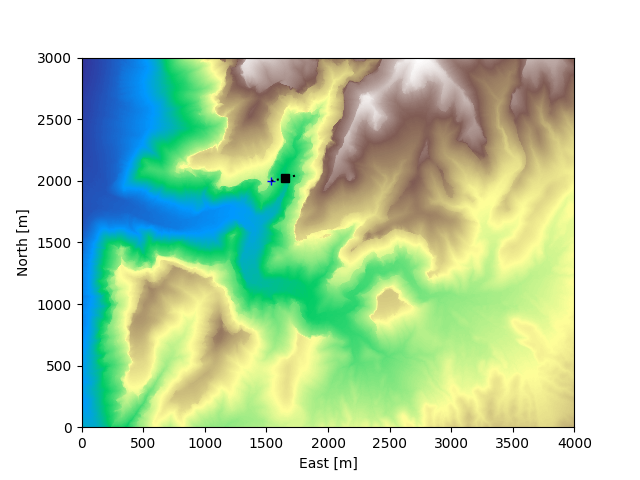

In [20]:
#e,n,u = dem.latlon_to_enu(39.247907, -113.402715)
#u = dem.interp_alt(e, n)
#print(e, n, u)
fig, ax = plt.subplots()
e0, n0, u0 = dem['platform']
rng = 750
plot_img(ax, dem.data, dem.res)
plt.plot([e0], [n0], 's', color='k')
for img in imgs[-1:]:
    e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
    plt.plot([e], [n], '+', color='blue')
    ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
    plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
    trace = traces[img.key]
    # try:
    #     plt.plot(np.asarray(trace.posterior[f'{img.key}_e']).flatten(), np.asarray(trace.posterior[f'{img.key}_n']).flatten(), '.');
    # except(KeyError):
    plt.plot(np.asarray(trace.posterior['e']).flatten(), np.asarray(trace.posterior['n']).flatten(), '.');


In [ ]:
summary = arviz.summary(posterior)
summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ant_e[0],1803.903,0.101,1803.718,1804.092,0.003,0.002,1150.0,1057.0,1.01
ant_e[1],1803.906,0.102,1803.704,1804.080,0.003,0.002,1011.0,1219.0,1.01
ant_e[2],1803.904,0.103,1803.721,1804.100,0.003,0.003,1175.0,1136.0,1.00
ant_n[0],1805.392,6.433,1803.579,1810.327,1.100,2.652,116.0,42.0,1.03
ant_n[1],1806.847,11.690,1803.559,1822.246,2.941,6.103,47.0,21.0,1.06
ant_n[2],1804.954,6.414,1803.691,1804.149,1.412,4.257,109.0,24.0,1.04
ant_u[0],1803.898,0.106,1803.707,1804.102,0.003,0.002,1493.0,1710.0,1.00
ant_u[1],1803.900,0.103,1803.719,1804.104,0.002,0.002,1808.0,1664.0,1.00
ant_u[2],1803.903,0.100,1803.724,1804.102,0.002,0.002,1756.0,2153.0,1.00


In [ ]:
avgs = summary['mean']
mean_ant_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
mean_ant_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
mean_ant_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

print(f'antenna enu from mcmc: e: {np.round(mean_ant_e)}, n:{np.round(mean_ant_n)}, u:{np.round(mean_ant_u)}')


antenna enu from mcmc: e: 1804.0, n:1806.0, u:1804.0


In [ ]:
avgs = summary['r_hat']
mean_r_hat_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
mean_r_hat_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
mean_r_hat_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

print(f'antenna r_hat from mcmc: e: {mean_r_hat_e}, n:{mean_r_hat_n}, u:{mean_r_hat_u}')


antenna r_hat from mcmc: e: 1.0066666666666666, n:1.0433333333333332, u:1.0


In [ ]:
avgs = summary['ess_bulk']
mean_ess_bulk_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
mean_ess_bulk_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
mean_ess_bulk_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

print(f'antenna ess_bulk from mcmc: e: {mean_ess_bulk_e}, n:{mean_ess_bulk_n}, u:{mean_ess_bulk_u}')


antenna r_hat from mcmc: e: 1112.0, n:90.66666666666667, u:1685.6666666666667


array([[<Axes: title={'center': 'ant_e'}>,
        <Axes: title={'center': 'ant_e'}>],
       [<Axes: title={'center': 'ant_n'}>,
        <Axes: title={'center': 'ant_n'}>],
       [<Axes: title={'center': 'ant_u'}>,
        <Axes: title={'center': 'ant_u'}>]], dtype=object)

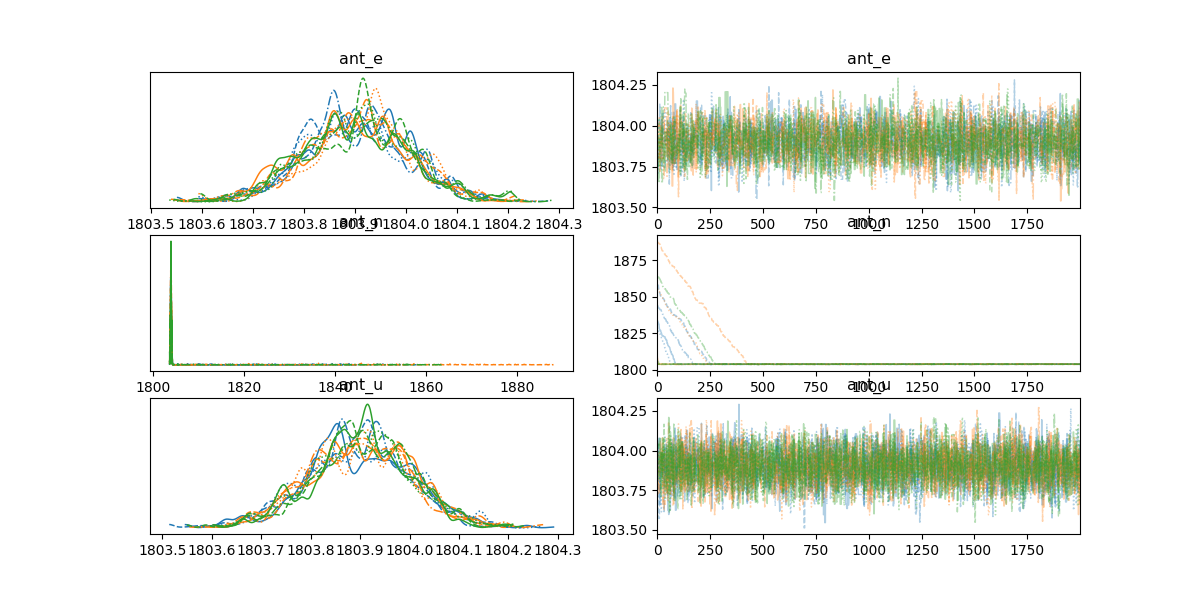

In [ ]:
arviz.plot_trace(posterior)


array([[<Axes: title={'center': 'ant_e\n0, 0'}>,
        <Axes: title={'center': 'ant_e\n0, 1'}>,
        <Axes: title={'center': 'ant_e\n0, 2'}>,
        <Axes: title={'center': 'ant_e\n1, 0'}>],
       [<Axes: title={'center': 'ant_e\n1, 1'}>,
        <Axes: title={'center': 'ant_e\n1, 2'}>,
        <Axes: title={'center': 'ant_e\n2, 0'}>,
        <Axes: title={'center': 'ant_e\n2, 1'}>],
       [<Axes: title={'center': 'ant_e\n2, 2'}>,
        <Axes: title={'center': 'ant_e\n3, 0'}>,
        <Axes: title={'center': 'ant_e\n3, 1'}>,
        <Axes: title={'center': 'ant_e\n3, 2'}>],
       [<Axes: title={'center': 'ant_n\n0, 0'}>,
        <Axes: title={'center': 'ant_n\n0, 1'}>,
        <Axes: title={'center': 'ant_n\n0, 2'}>,
        <Axes: title={'center': 'ant_n\n1, 0'}>],
       [<Axes: title={'center': 'ant_n\n1, 1'}>,
        <Axes: title={'center': 'ant_n\n1, 2'}>,
        <Axes: title={'center': 'ant_n\n2, 0'}>,
        <Axes: title={'center': 'ant_n\n2, 1'}>],
       [<Axes: 

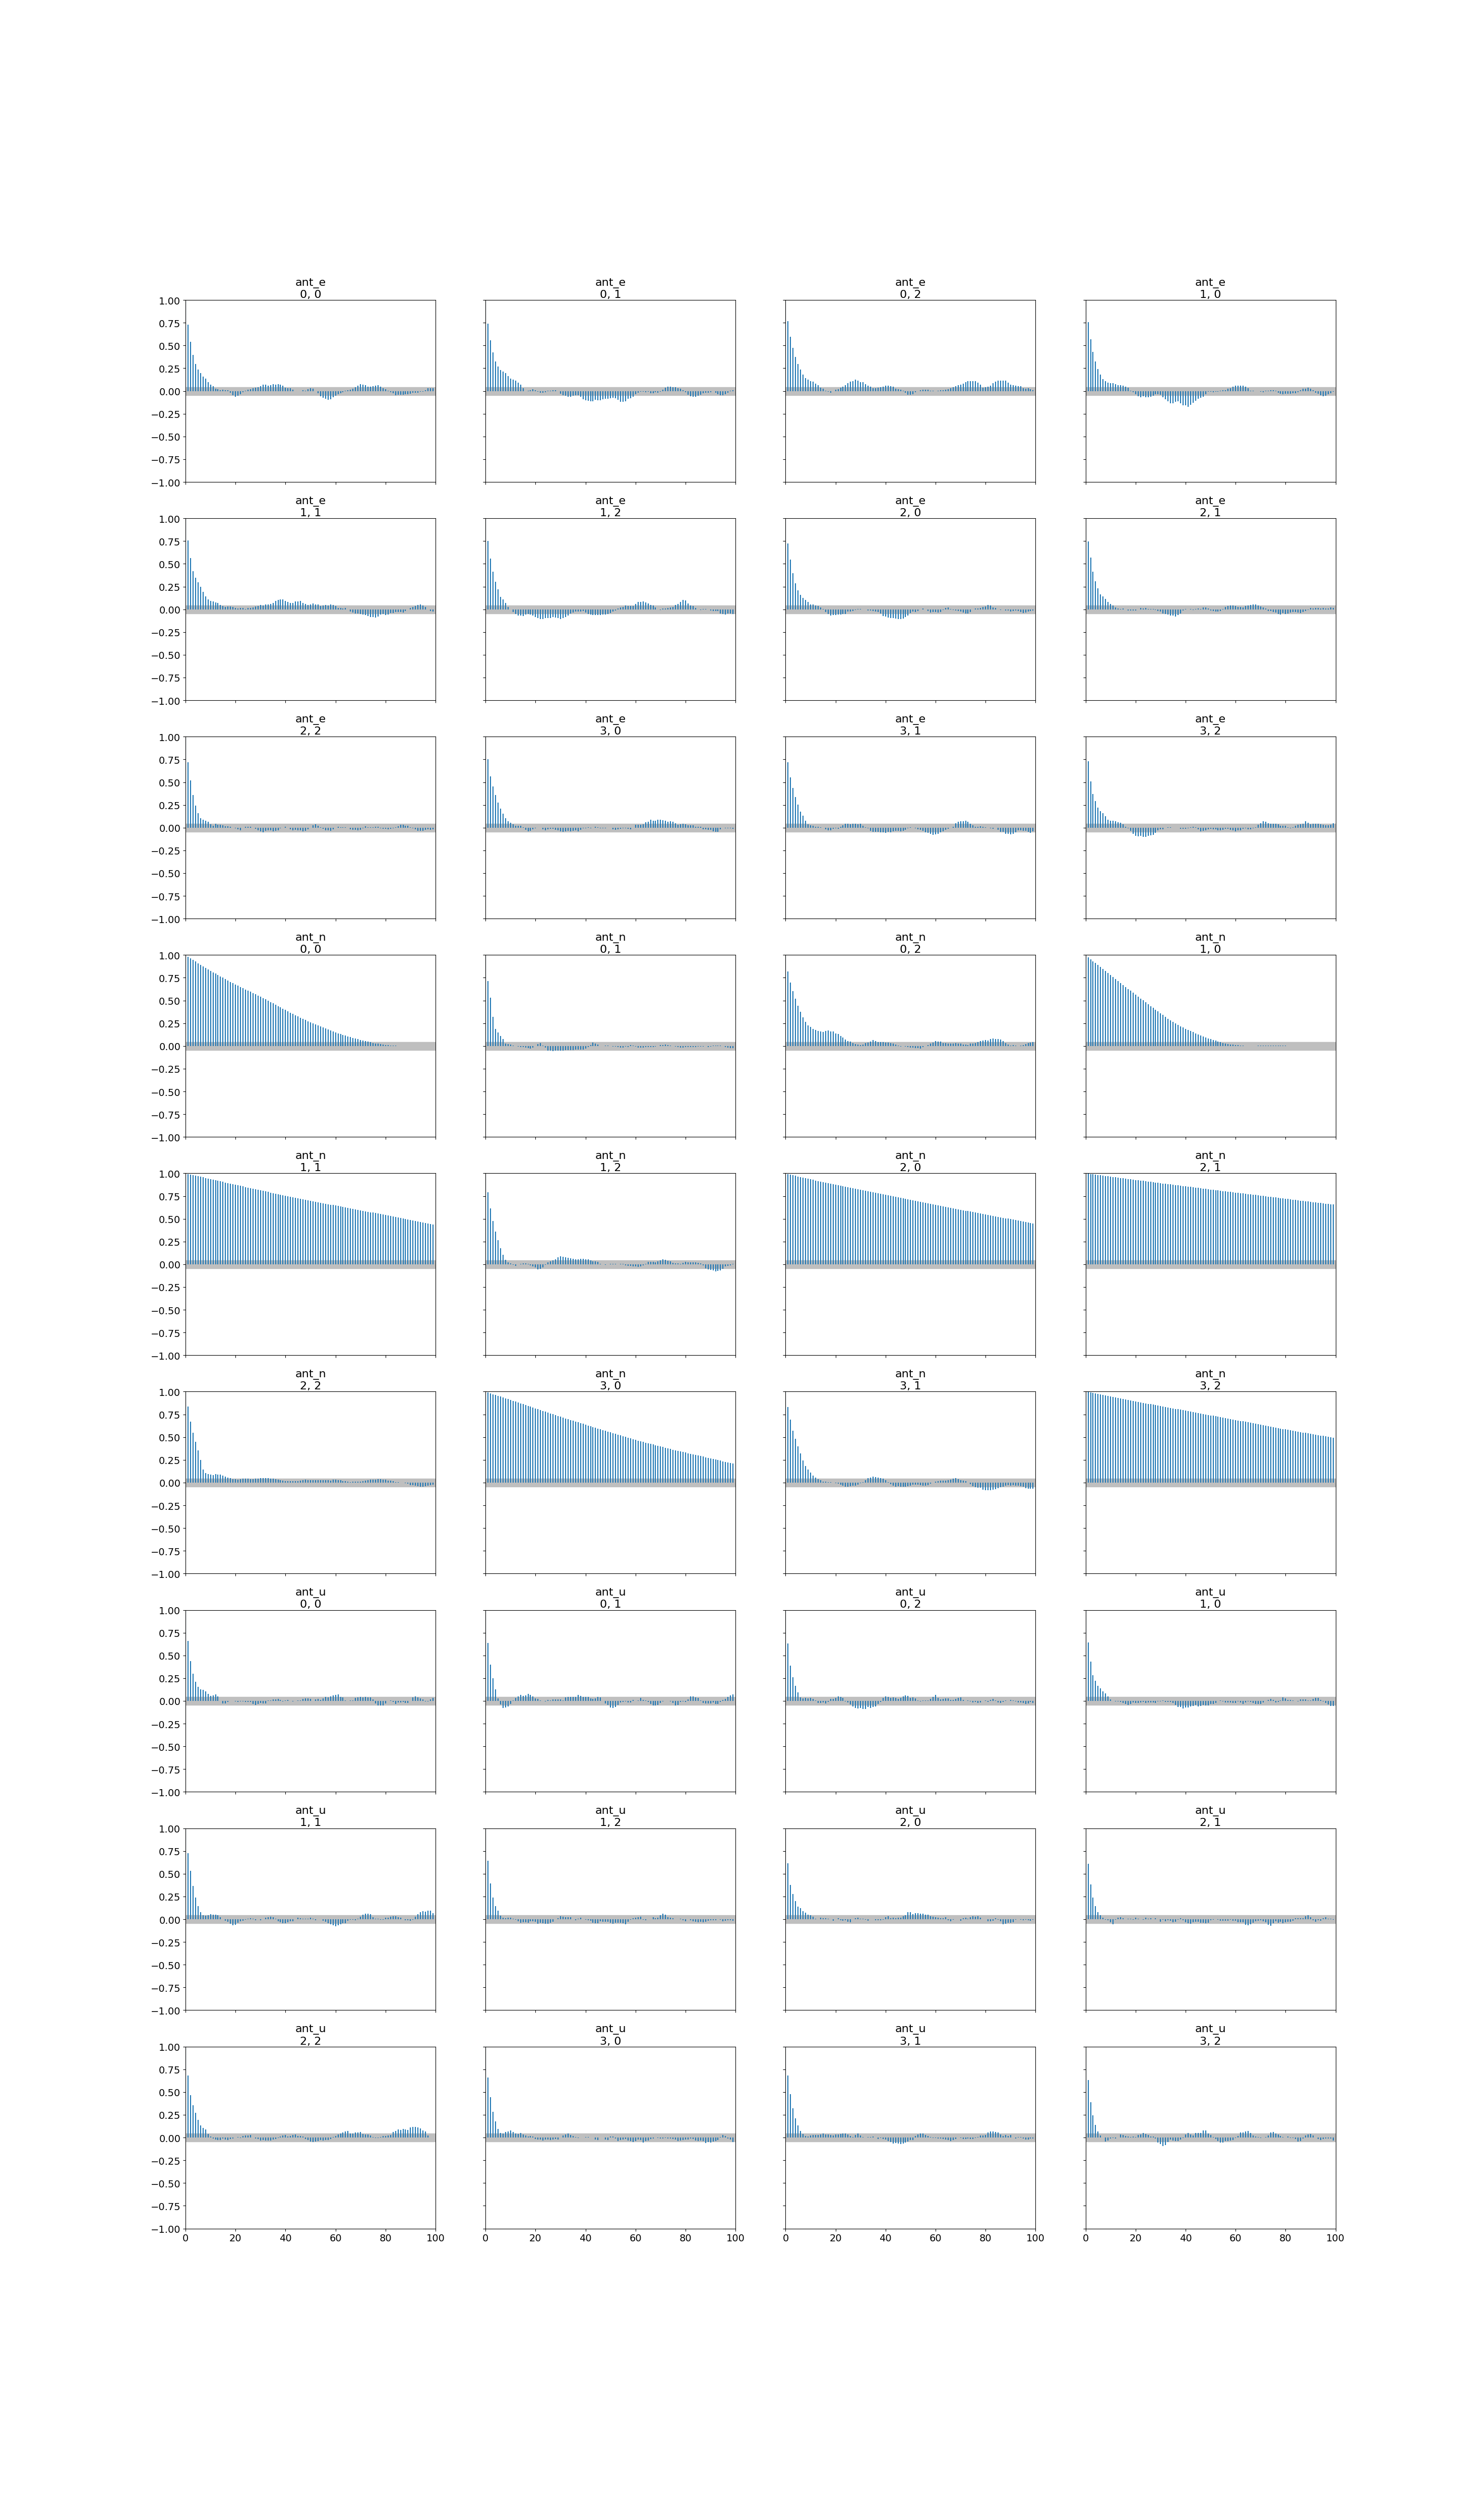

In [ ]:
arviz.plot_autocorr(posterior)


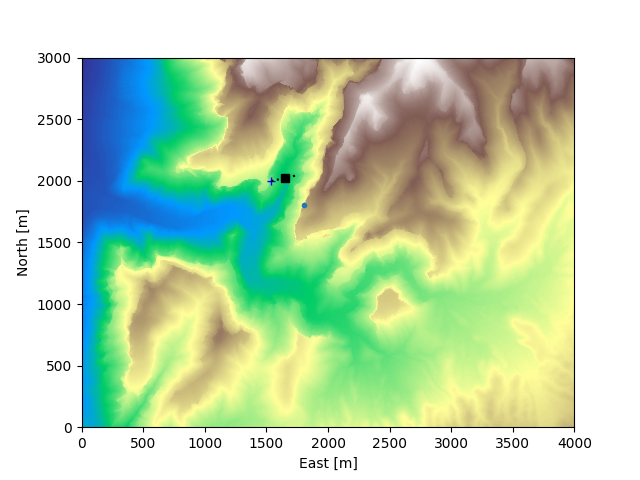

In [ ]:
#e,n,u = dem.latlon_to_enu(39.247907, -113.402715)
#u = dem.interp_alt(e, n)
#print(e, n, u)
fig, ax = plt.subplots()
e0, n0, u0 = dem['platform']
rng = 750
plot_img(ax, dem.data, dem.res)
plt.plot([e0], [n0], 's', color='k')
for img in imgs[-1:]:
    e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
    plt.plot([e], [n], '+', color='blue')
    ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
    plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
    trace = traces[img.key]
    # try:
    #     plt.plot(np.asarray(trace.posterior[f'{img.key}_e']).flatten(), np.asarray(trace.posterior[f'{img.key}_n']).flatten(), '.');
    # except(KeyError):
    plt.plot(mean_ant_e, mean_ant_n, '.');


In [ ]:
theta = np.array([mean_ant_e, mean_ant_n, mean_ant_u])
# theta = ant_pos_prior
pos_slvr.set_mcmc_prms(theta)
logp = pos_slvr.total_loss(theta)
logp


logp -0.0
logL -564386.3104180708
logp -564386.3104180708
logL -405538.6404572821
logp -969924.9508753528
logL -506027.6392619485


-1475952.5901373015